In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import copy
# %matploblib inline

In [2]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats/celltrack_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats_mpgrid/celltrack_stats/'
os.makedirs(figdir, exist_ok=True)

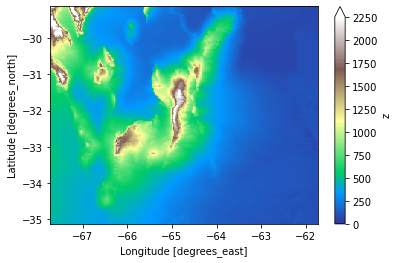

In [3]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [4]:
xr.set_options(display_style='text', display_width=100) 

In [5]:
# Read 2D track data
stats = xr.open_dataset(stats_file)
stats.dims['tracks']

6895

In [6]:
# Read 3D data
stats3d = xr.open_dataset(stats_file3d)
stats3d.dims['tracks']

6895

In [7]:
# Combine 2D and 3D datasets by coordinates
stats = xr.combine_by_coords([stats, stats3d], combine_attrs='override')
stats

<xarray.Dataset>
Dimensions:                  (times: 60, tracks: 6895, z: 45)
Coordinates:
  * tracks                   (tracks) int32 0 1 2 3 4 5 6 7 ... 6888 6889 6890 6891 6892 6893 6894
  * times                    (times) int32 0 1 2 3 4 5 6 7 8 9 10 ... 50 51 52 53 54 55 56 57 58 59
  * z                        (z) float64 0.0 500.0 1e+03 1.5e+03 ... 2.1e+04 2.15e+04 2.2e+04
Data variables: (12/63)
    lifetime                 (tracks) float64 ...
    basetime                 (tracks, times) datetime64[ns] 2018-10-16T12:45:00 ... 1969-12-31T21...
    core_meanlat             (tracks, times) float32 ...
    core_meanlon             (tracks, times) float32 ...
    core_mean_y              (tracks, times) float32 ...
    core_mean_x              (tracks, times) float32 ...
    ...                       ...
    max_zdr                  (tracks, times, z) float32 ...
    max_kdp                  (tracks, times, z) float32 ...
    max_rainrate             (tracks, times, z) float32 ...
    max_Dm                   (tracks, times, z) float32 ...
    max_lwc                  (tracks, times, z) float32 ...
    volrain                  (tracks, times, z) float32 ...
Attributes: (12/13)
    title:                 File containing statistics for each track
    Institution:           Pacific Northwest National Laboratoy
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Fri Feb 26 10:40:33 2021
    source:                CSAPR2
    description:           COR
    ...                    ...
    enddate:               20190303.0000
    track_version:         v1.0
    tracknumbers_version:  v1.0
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       0.5

In [8]:
tracks = stats['tracks']
times = stats['times']
height = stats['z'] / 1000.
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [9]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [10]:
# lifetime = lifetime.isel(tracks=ind)
# start_time = start_time.isel(tracks=ind)
# end_time = end_time.isel(tracks=ind)
# end_merge_tracknumber = end_merge_tracknumber.isel(tracks=ind)
# start_split_tracknumber = start_split_tracknumber.isel(tracks=ind)
# cell_lon = cell_lon.isel(tracks=ind)
# cell_lat = cell_lat.isel(tracks=ind)
# cell_area = cell_area.isel(tracks=ind)
# maxrange_flag = maxrange_flag.isel(tracks=ind)
# eth10 = eth10.isel(tracks=ind)
# eth20 = eth20.isel(tracks=ind)
# eth30 = eth30.isel(tracks=ind)
# eth40 = eth40.isel(tracks=ind)
# eth50 = eth50.isel(tracks=ind)

In [11]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [12]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [13]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)
hist_starthour, bins = np.histogram(start_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

In [14]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [1]:
# # Bin max cell diameter data by initiation hour for box plot
# cell_diam_max_hourbin = []
# cell_eth20_max_hourbin = []
# for ihour in range(24):
#     cell_diam_max_hourbin.append(cell_diam_max.where(start_hour == ihour, drop=True).values)
#     cell_eth20_max_hourbin.append(cell_eth20_max.where((start_hour == ihour) & (~np.isnan(cell_eth20_max)), drop=True).values)

# # Convert to local time (UTC-3) 
# # cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# # To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# # Convert the ragged list to a numpy object array
# cell_diam_max_hourbin = np.array(cell_diam_max_hourbin, dtype=object, copy=False, subok=True)
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# cell_eth20_max_hourbin = np.array(cell_eth20_max_hourbin, dtype=object, copy=False, subok=True)
# cell_eth20_max_hourbin_LT = np.roll(cell_eth20_max_hourbin, -3)

In [2]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='Track Start')
# ax1.plot(hour_binv, hist_endhour_LT, color='dodgerblue', lw=2, label='Track End')
# ax1.legend()
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Times (Non-merge)', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour)')
# ax1.set_ylim(100, 300)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_nonmerge.png', bbox_inches='tight', dpi=300)

In [3]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig = plt.figure(figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
# meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# ax = plt.subplot(111)
# bp1 = ax.boxplot(cell_diam_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax.grid(ls='--')
# ax.set_title('Cell Max Diameter', loc='left')
# ax.set_ylabel('Cell Max Diameter (km)')
# ax.set_xlabel('Local Time (hour)')
# # ax.set_ylim(100, 300)
# ax.set_xticks(np.arange(0,24.1,3))
# ax.set_xlim(0,24)

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_maxdiam_boxplot.png', bbox_inches='tight', dpi=300)

In [4]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig = plt.figure(figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='lightseagreen', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
# meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='lightseagreen')

# ax = plt.subplot(111)
# bp1 = ax.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax.grid(ls='--')
# ax.set_title('Cell Max Echo-top', loc='left')
# ax.set_ylabel('Cell Max 20dBZ ETH (km)')
# ax.set_xlabel('Local Time (hour)')
# # ax.set_ylim(100, 300)
# ax.set_xticks(np.arange(0,24.1,3))
# ax.set_xlim(0,24)

# fig.tight_layout()
# # fig.savefig(f'{figdir}celltrack_diurnal_maxdiam_boxplot.png', bbox_inches='tight', dpi=300)

In [5]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='Track Initiation')
# # ax1.plot(hour_binv, hist_endhour_LT, color='dodgerblue', lw=2, label='Track End')
# ax1.legend()
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour)')
# ax1.set_ylim(100, 320)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# # ax1.spines['left'].set_color('tomato')
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
# meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_diam_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Cell Max Diameter (km)', color='dodgerblue')
# ax2.set_ylim(4, 18)
# ax2.tick_params(axis='y', labelcolor='dodgerblue')
# ax2.spines['left'].set_color('tomato')
# ax2.spines['right'].set_color('dodgerblue')

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxdiam_boxplot.png', bbox_inches='tight', dpi=300)

In [6]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='Track Initiation')
# # ax1.plot(hour_binv, hist_endhour_LT, color='dodgerblue', lw=2, label='Track End')
# ax1.legend()
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour)')
# ax1.set_ylim(100, 320)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# # ax1.spines['left'].set_color('tomato')
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='lightseagreen', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
# meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='lightseagreen')

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Cell Max 20dBZ ETH (km)', color='lightseagreen')
# ax2.set_ylim(2, 16)
# ax2.tick_params(axis='y', labelcolor='lightseagreen')
# ax2.spines['left'].set_color('tomato')
# ax2.spines['right'].set_color('lightseagreen')

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxETH20dbz_boxplot.png', bbox_inches='tight', dpi=300)

In [7]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

# ax1 = axes[0]
# ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
# ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
# ax1.legend()
# ax1.grid(ls='--')
# ax1.set_title('(a) Cell Track Start Times', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour)')
# ax1.set_ylim(100, 300)

# ax2 = axes[1]
# ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
# ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
# ax2.legend()
# ax2.grid(ls='--')
# ax2.set_title('(b) Cell Track End Times', loc='left')
# ax2.set_ylabel('Number of Tracks')
# ax2.set_xlabel('Local Time (hour)')
# ax2.set_ylim(100, 300)

# fig.tight_layout()

In [8]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# # ax1 = fig.add_subplot(1,1,1)
# ax1.set_xlabel('Lifetime (hour)')
# ax1.set_ylabel('Number')
# ax1.hist(lifetime, bins=np.arange(21)*0.25, density=False, label='All Tracks', width=0.1, alpha=0.6)
# ax1.hist(lifetime.isel(tracks=nonmerge), bins=np.arange(21)*0.25, density=False, label='Non-merge Tracks', width=0.2, alpha=0.6)
# ax1.legend()
# ax1.set_xlim(0, 5)
# ax1.set_title('Cell Lifetime', loc='left')
# ax1.grid(ls='--')
# ax1.set_yscale('log')
# fig.savefig(f'{figdir}celltrack_lifetime_pdf.png', bbox_inches='tight', dpi=300)

In [27]:
quantiles = [0.5,0.75,0.9,0.95]
lifetime_range1 = [0.4,0.5]
lifetime_range2 = [0.9,1]
lifetime_range3 = [1.9,2]
cell_area1 = stats.cell_area.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area2 = stats.cell_area.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area3 = stats.cell_area.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
quantiles_2Dvar = [0.25,0.5,0.75,0.9,0.95]
cell_area1_pts = cell_area1.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area2_pts = cell_area2.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area3_pts = cell_area3.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

/global/cfs/cdirs/m1867/zfeng/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [28]:
max_dbz1 = stats.max_reflectivity.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz2 = stats.max_reflectivity.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz3 = stats.max_reflectivity.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
# Replace NaN with a large negative value to take into account decreasing sample with height
# NaN is excluded in quantile calculations which biases the sampling with increasing height
fillval = -99
max_dbz1 = max_dbz1.where(~np.isnan(max_dbz1), other=fillval)
max_dbz2 = max_dbz2.where(~np.isnan(max_dbz2), other=fillval)
max_dbz3 = max_dbz3.where(~np.isnan(max_dbz3), other=fillval)
ntracks1 = max_dbz1.sizes['tracks']
ntracks2 = max_dbz2.sizes['tracks']
ntracks3 = max_dbz3.sizes['tracks']
print(f'Number of tracks: {ntracks1}, {ntracks2}, {ntracks3}')
max_dbz_dur1_pts = max_dbz1.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur2_pts = max_dbz2.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur3_pts = max_dbz3.quantile(quantiles, dim='tracks', skipna=True)

Number of tracks: 2140, 508, 103


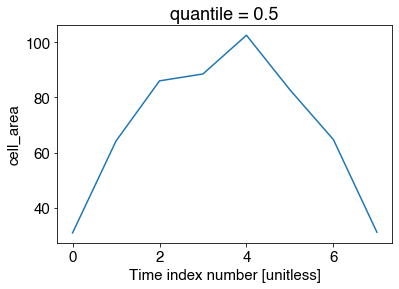

In [29]:
cell_area3_pts.sel(quantile=0.5).plot()

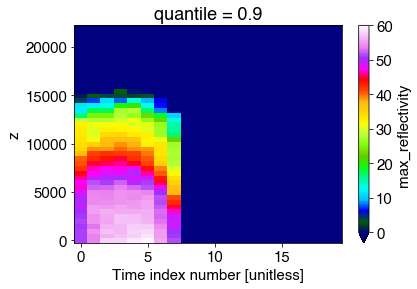

In [30]:
qntl=0.9
max_dbz_dur3_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=60, cmap='gist_ncar')

In [31]:
dbz30_diam1 = 2 * np.sqrt(stats.npix_dbz30.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam2 = 2 * np.sqrt(stats.npix_dbz30.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam3 = 2 * np.sqrt(stats.npix_dbz30.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz30_diam1 = dbz30_diam1.where(~np.isnan(dbz30_diam1), other=fillval)
dbz30_diam2 = dbz30_diam2.where(~np.isnan(dbz30_diam2), other=fillval)
dbz30_diam3 = dbz30_diam3.where(~np.isnan(dbz30_diam3), other=fillval)
dbz30_diam1_pts = dbz30_diam1.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam2_pts = dbz30_diam2.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam3_pts = dbz30_diam3.quantile(quantiles, dim='tracks', skipna=True)

In [32]:
dbz40_diam1 = 2 * np.sqrt(stats.npix_dbz40.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam2 = 2 * np.sqrt(stats.npix_dbz40.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam3 = 2 * np.sqrt(stats.npix_dbz40.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz40_diam1 = dbz40_diam1.where(~np.isnan(dbz40_diam1), other=fillval)
dbz40_diam2 = dbz40_diam2.where(~np.isnan(dbz40_diam2), other=fillval)
dbz40_diam3 = dbz40_diam3.where(~np.isnan(dbz40_diam3), other=fillval)
dbz40_diam1_pts = dbz40_diam1.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam2_pts = dbz40_diam2.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam3_pts = dbz40_diam3.quantile(quantiles, dim='tracks', skipna=True)

In [33]:
max_zdr1 = stats.max_zdr.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr2 = stats.max_zdr.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr3 = stats.max_zdr.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_zdr1 = max_zdr1.where(~np.isnan(max_zdr1), other=fillval)
max_zdr2 = max_zdr2.where(~np.isnan(max_zdr2), other=fillval)
max_zdr3 = max_zdr3.where(~np.isnan(max_zdr3), other=fillval)
max_zdr1_pts = max_zdr1.quantile(quantiles, dim='tracks', skipna=True)
max_zdr2_pts = max_zdr2.quantile(quantiles, dim='tracks', skipna=True)
max_zdr3_pts = max_zdr3.quantile(quantiles, dim='tracks', skipna=True)

In [34]:
max_kdp1 = stats.max_kdp.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp2 = stats.max_kdp.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp3 = stats.max_kdp.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_kdp1 = max_kdp1.where(~np.isnan(max_kdp1), other=fillval)
max_kdp2 = max_kdp2.where(~np.isnan(max_kdp2), other=fillval)
max_kdp3 = max_kdp3.where(~np.isnan(max_kdp3), other=fillval)
max_kdp1_pts = max_kdp1.quantile(quantiles, dim='tracks', skipna=True)
max_kdp2_pts = max_kdp2.quantile(quantiles, dim='tracks', skipna=True)
max_kdp3_pts = max_kdp3.quantile(quantiles, dim='tracks', skipna=True)

In [35]:
max_rainrate1 = stats.max_rainrate.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate2 = stats.max_rainrate.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate3 = stats.max_rainrate.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_rainrate1 = max_rainrate1.where(~np.isnan(max_rainrate1), other=fillval)
max_rainrate2 = max_rainrate2.where(~np.isnan(max_rainrate2), other=fillval)
max_rainrate3 = max_rainrate3.where(~np.isnan(max_rainrate3), other=fillval)
max_rainrate1_pts = max_rainrate1.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate2_pts = max_rainrate2.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate3_pts = max_rainrate3.quantile(quantiles, dim='tracks', skipna=True)

In [36]:
max_Dm1 = stats.max_Dm.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm2 = stats.max_Dm.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm3 = stats.max_Dm.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_Dm1 = max_Dm1.where(~np.isnan(max_Dm1), other=fillval)
max_Dm2 = max_Dm2.where(~np.isnan(max_Dm2), other=fillval)
max_Dm3 = max_Dm3.where(~np.isnan(max_Dm3), other=fillval)
max_Dm1_pts = max_Dm1.quantile(quantiles, dim='tracks', skipna=True)
max_Dm2_pts = max_Dm2.quantile(quantiles, dim='tracks', skipna=True)
max_Dm3_pts = max_Dm3.quantile(quantiles, dim='tracks', skipna=True)

In [37]:
volrain1 = stats.volrain.where((lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain2 = stats.volrain.where((lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain3 = stats.volrain.where((lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
volrain1 = volrain1.where(~np.isnan(volrain1), other=fillval)
volrain2 = volrain2.where(~np.isnan(volrain2), other=fillval)
volrain3 = volrain3.where(~np.isnan(volrain3), other=fillval)
volrain1_pts = volrain1.quantile(quantiles, dim='tracks', skipna=True)
volrain2_pts = volrain2.quantile(quantiles, dim='tracks', skipna=True)
volrain3_pts = volrain3.quantile(quantiles, dim='tracks', skipna=True)

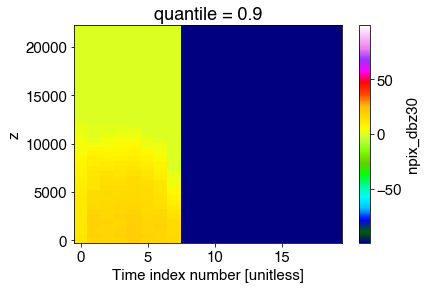

In [38]:
dbz30_diam3_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(cmap='gist_ncar')

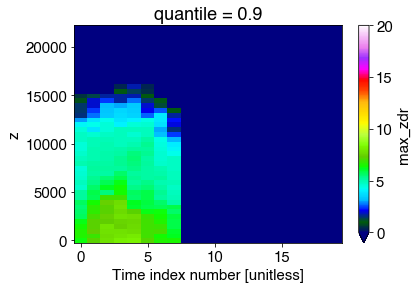

In [39]:
max_zdr3_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=20, cmap='gist_ncar')

In [40]:
def plot_timeheight_3panel(times, heights, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, quantile, figname, oob_colors=None):

    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    fig, axs = plt.subplots(1, 3, figsize=[15,4], dpi=100)

    cmap = copy.copy(plt.get_cmap(cmap))
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    xlabels = 'Hour since initiation'
    ylabels = ['Height (km)','','']

    pcm_save = []
    for col in range(3):
        ax1 = axs[col]
        Zm = np.ma.masked_invalid(dataarr[col])
        Zm = np.ma.masked_where(Zm <= 0, Zm)
        pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels)
        ax1.set_ylabel(ylabels[col])
        ax1.set_title(titles[col], loc='left', fontsize=16)
        ax1.set_title(f'{quantile:.0f}'+'$^{th}$ percentile', loc='right', fontsize=12)
        ax1.set_xlim(np.min(xlims), np.max(xlims))
        ax1.set_ylim(np.min(ylims), np.max(ylims))
        ax1.set_yticks(yticks)
        ax1.grid(ls='--')
        if oob_colors is not None:
            pcm.cmap.set_over(oob_colors['over'])
            pcm.cmap.set_under(oob_colors['under'])
            pcm.set_clim(min(levels), max(levels))
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

    # Adjust the layout before plotting colorbar
    fig.tight_layout()

    # Colorbar
    cbar = fig.colorbar(pcm_save[0], ax=axs[:], shrink=1, pad=0.02, label=cblabel, extend='both')
    cbar.set_ticks(cbticks)

    fig.savefig(figname, bbox_inches='tight', dpi=300)

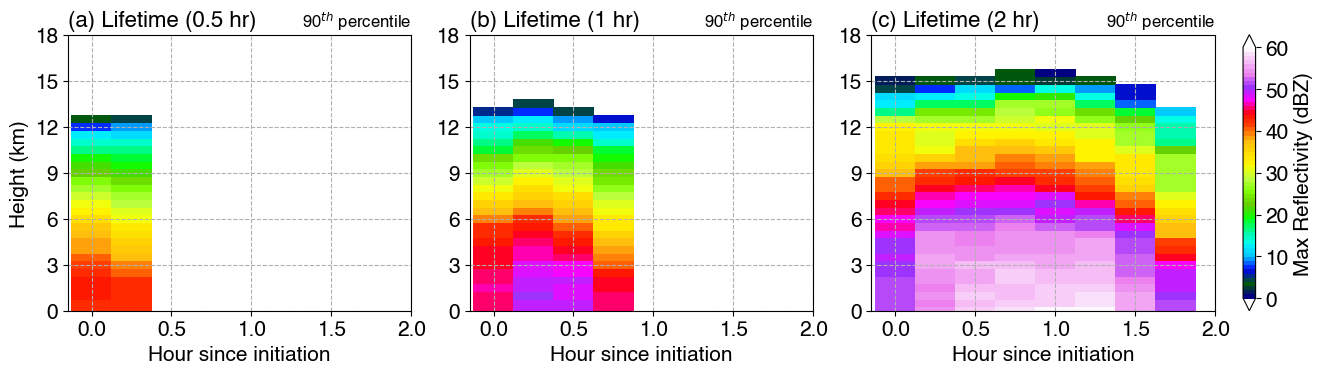

In [41]:
times_hour = times * time_res

qntl = 0.9
dataarr = [max_dbz_dur1_pts.sel(quantile=qntl).transpose(), max_dbz_dur2_pts.sel(quantile=qntl).transpose(), max_dbz_dur3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 60.1, 1)
cbticks = np.arange(0, 60.1, 10)
cmap = 'gist_ncar'
xlims = (-0.15,2)
ylims = (0,18)
yticks = np.arange(0,18.1,3)
# titles = [f'(a) Lifetime ({lifetime_range1[0]}-{lifetime_range1[1]} hr)', 
#           f'(b) Lifetime ({lifetime_range2[0]}-{lifetime_range2[1]} hr)', 
#           f'(c) Lifetime ({lifetime_range3[0]}-{lifetime_range3[1]} hr)']
titles = [f'(a) Lifetime ({lifetime_range1[1]} hr)', 
          f'(b) Lifetime ({lifetime_range2[1]} hr)', 
          f'(c) Lifetime ({lifetime_range3[1]} hr)']
cblabel = 'Max Reflectivity (dBZ)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

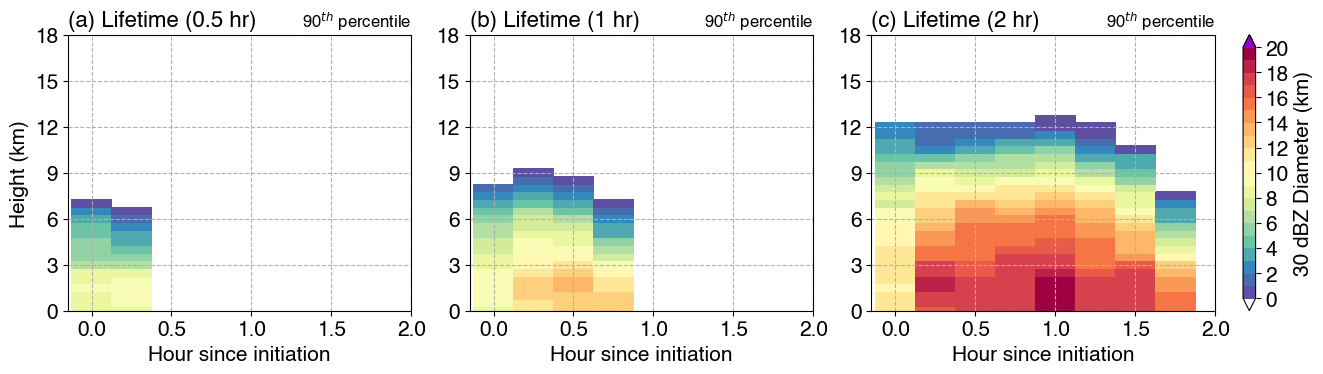

In [42]:
qntl = 0.9
dataarr = [dbz30_diam1_pts.sel(quantile=qntl).transpose(), dbz30_diam2_pts.sel(quantile=qntl).transpose(), dbz30_diam3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
cmap = 'Spectral_r'
cblabel = '30 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter30dbz_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

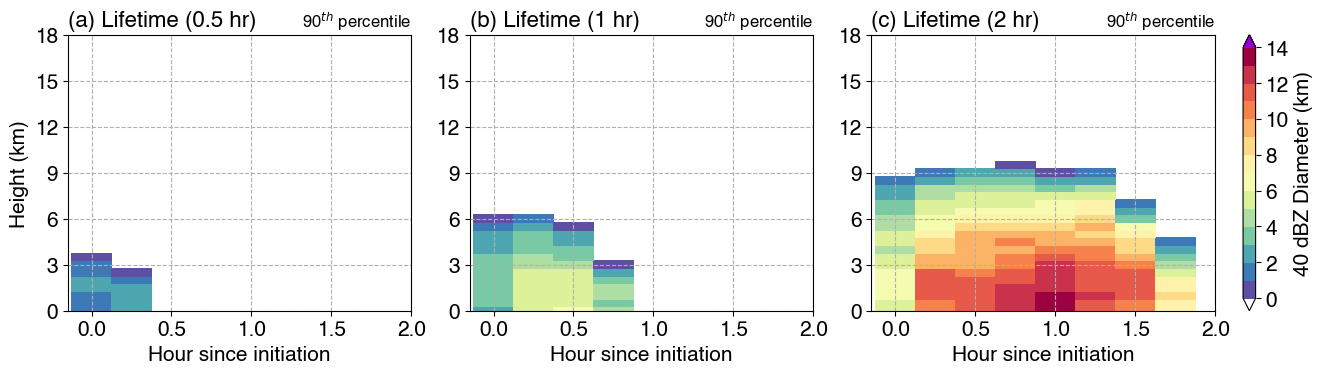

In [43]:
qntl = 0.9
dataarr = [dbz40_diam1_pts.sel(quantile=qntl).transpose(), dbz40_diam2_pts.sel(quantile=qntl).transpose(), dbz40_diam3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 14.1, 1)
# levels[0] = 0.1
cbticks = np.arange(0, 14.1, 2)
cmap = 'Spectral_r'
cblabel = '40 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter40dbz_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

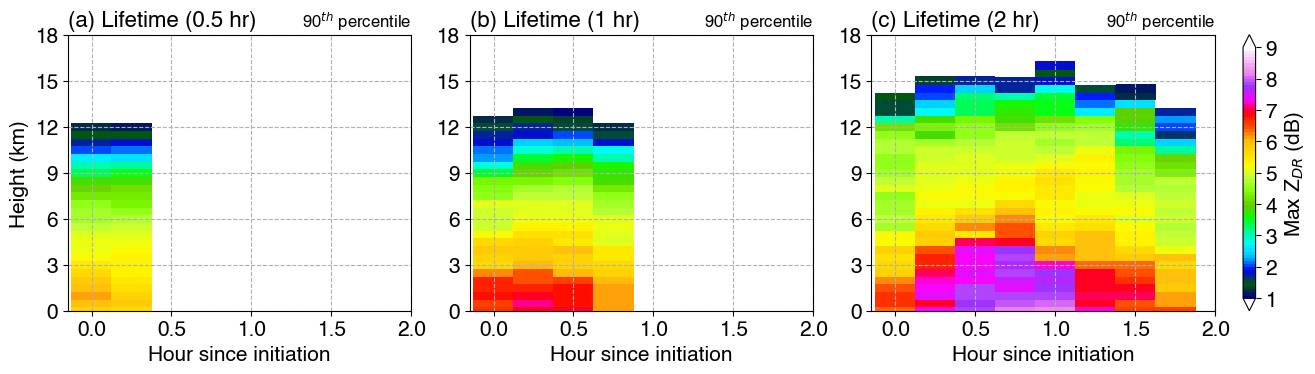

In [44]:
qntl = 0.9
dataarr = [max_zdr1_pts.sel(quantile=qntl).transpose(), max_zdr2_pts.sel(quantile=qntl).transpose(), max_zdr3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(1, 9.1, 0.1)
cbticks = np.arange(1, 9.1, 1)
cmap = 'gist_ncar'
cblabel = 'Max Z$_{DR}$ (dB)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

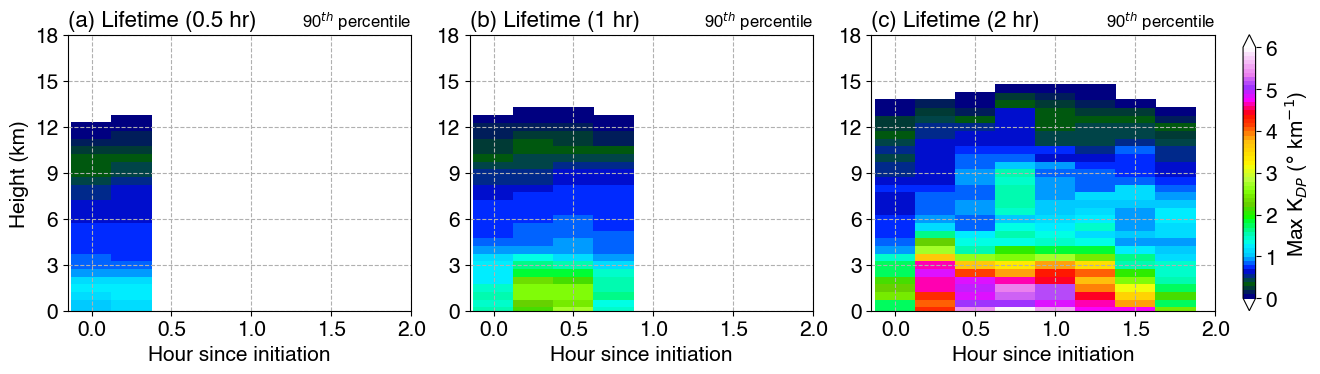

In [45]:
qntl = 0.9
dataarr = [max_kdp1_pts.sel(quantile=qntl).transpose(), max_kdp2_pts.sel(quantile=qntl).transpose(), max_kdp3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 6.1, 0.1)
# levels[0] = 0.1
cbticks = np.arange(0, 6.1, 1)
cmap = 'gist_ncar'
cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

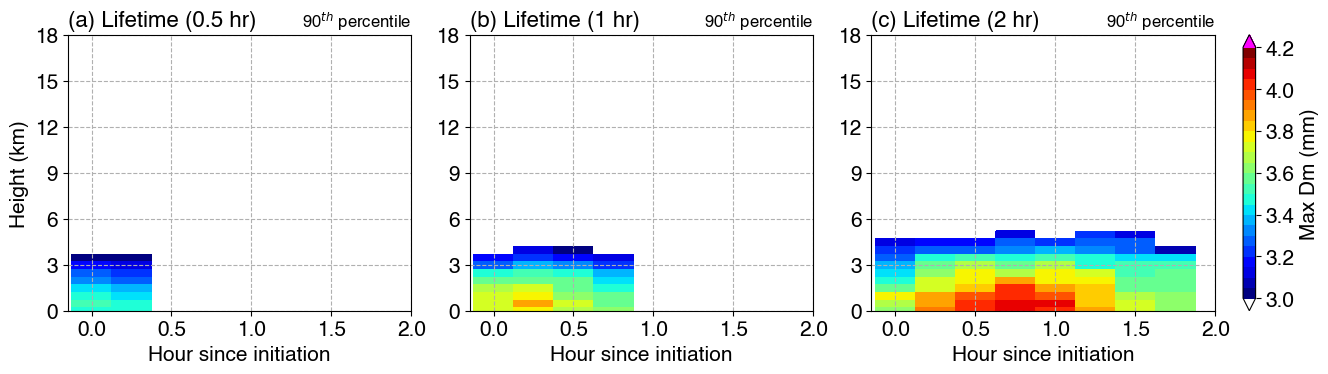

In [46]:
qntl = 0.9
dataarr = [max_Dm1_pts.sel(quantile=qntl).transpose(), max_Dm2_pts.sel(quantile=qntl).transpose(), max_Dm3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(3, 4.21, 0.05)
cbticks = np.arange(3, 4.21, 0.2)
cmap = 'jet'
cblabel = 'Max Dm (mm)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'magenta', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

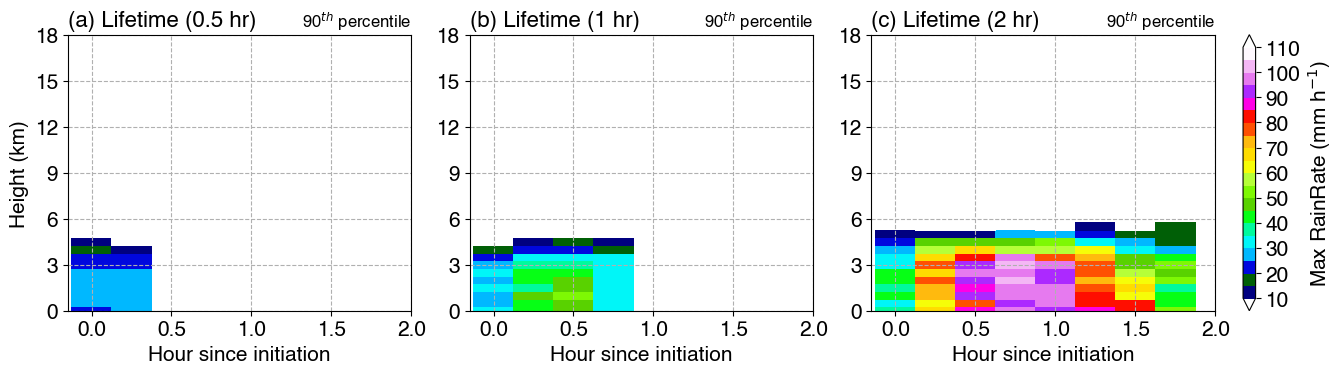

In [47]:
qntl = 0.9
dataarr = [max_rainrate1_pts.sel(quantile=qntl).transpose(), max_rainrate2_pts.sel(quantile=qntl).transpose(), max_rainrate3_pts.sel(quantile=qntl).transpose()]
levels = np.arange(10, 110.1, 5)
cbticks = np.arange(10, 110.1, 10)
cmap = 'gist_ncar'
cblabel = 'Max RainRate (mm h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

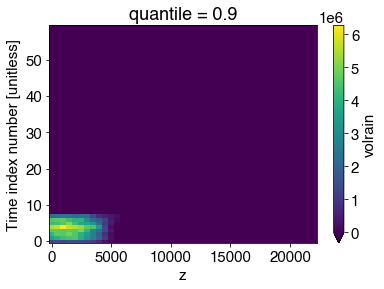

In [48]:
(volrain3_pts.sel(quantile=0.9)).plot(vmin=0)

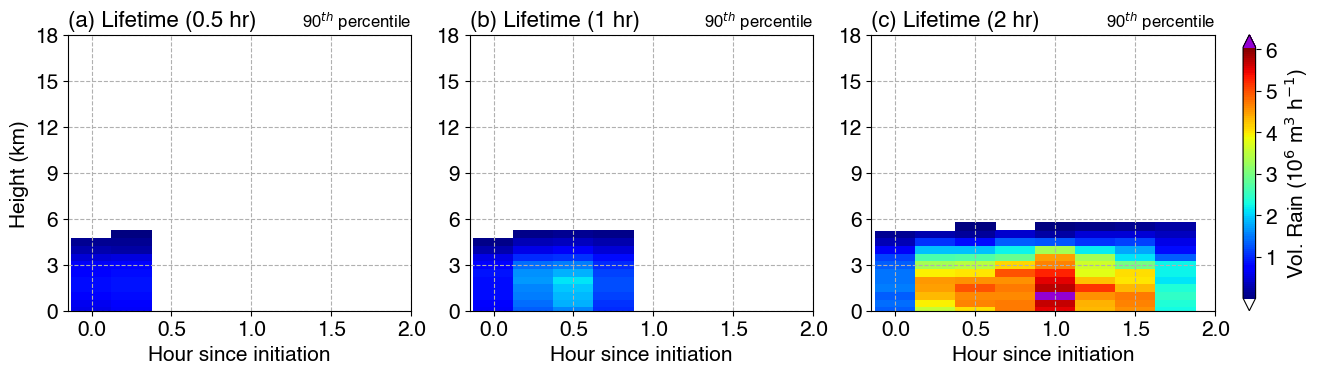

In [53]:
qntl = 0.9
scale = 1e6
dataarr = [volrain1_pts.sel(quantile=qntl).transpose()/scale, volrain2_pts.sel(quantile=qntl).transpose()/scale, volrain3_pts.sel(quantile=qntl).transpose()/scale]
levels = np.arange(0, 6.1, 0.05)
levels[0] = 0.01
cbticks = np.arange(0, 6.1, 1)
cmap = 'jet'
cblabel = 'Vol. Rain (10$^6$ m$^3$ h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_volrain_{qntl*100:.0f}quantile.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, figname, oob_colors=oob_colors)

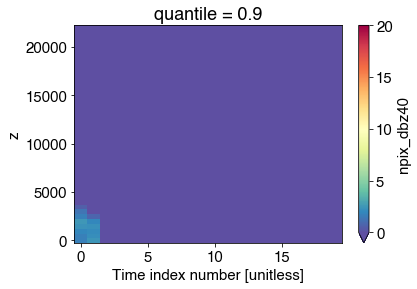

In [50]:
qntl=0.9
dbz40_diam1_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=20, cmap='Spectral_r')